## Demographic model testing

In this notebook, we're going to simulate data based on our best-fit model(s), and then compare the SFS from these data with the SFS from our empirical data. We'll start by importing the `Python` packages we'll use for demographic modeling:

In [4]:
# suppress gnarly matplotlib warnings
import warnings
def action_with_warnings():
    warnings.warn("should not appear")

# load other packages
import allel
import moments, sys, os, matplotlib, numpy as np
from moments import Misc,Spectrum,Numerics,Manips,Integration,Demographics1D,Demographics2D
import msprime
import tskit
import seaborn as sns

# set directory
os.chdir("/Users/ethanlinck/Dropbox/wagtails/")

Next, we'll load a vcf file, trim it for linkage disequilibrium, and write a joint site frequency spectrum to file:

In [3]:
# load vcf and extract folded sfs; write to file
vcf_file = "data/demographic_inf_parentals_rename.vcf"
f = allel.read_vcf(vcf_file, fields='*')
gt = f['calldata/GT']
gt = allel.GenotypeArray(gt)
personata=gt[:,0:10]
alba=gt[:,10:20]
gn_p = personata.to_n_alt(fill=-1)
gn_a = alba.to_n_alt(fill=-1)
p_unlinked = allel.locate_unlinked(gn_p)
a_unlinked = allel.locate_unlinked(gn_a)
pass_linkage = np.logical_and(p_unlinked, a_unlinked)
final = gt.compress(pass_linkage, axis=0)
personata2=final[:,0:10]
alba2=final[:,10:20]
pers_ac = personata2.count_alleles()
alba_ac = alba2.count_alleles()
fsfs = allel.joint_sfs_folded(pers_ac, alba_ac)
m_fsfs = moments.Spectrum(fsfs)
m_fsfs.to_file("allopatric_parental_unlinked_sfs.txt")

In [11]:
# suppress gnarly matplotlib warnings
import warnings
def action_with_warnings():
    warnings.warn("should not appear")

# import other libraries
import allel
import moments
import msprime
import tskit
import numpy as np
import seaborn as sns
import math

How many variants? We'll need this for our simulations.

In [5]:
variant_count = final.n_variants
variant_count

549501

Next, let's calculate basic summary statistics: $F_{ST}$, $\pi$, and $D_{XY}$. First, we'll assign subpopulations:

In [6]:
alba = list(range(0,10))
personata = list(range(10,20))
populations = [alba, personata]

Now, the summary stats themselves, which will save for comparison to simulated results later. Genome-wide $F_{ST}$:

In [7]:
a, b, c = allel.weir_cockerham_fst(final, populations)
empirical_fst = np.sum(a) / (np.sum(a) + np.sum(b) + np.sum(c))
empirical_fst

0.06371249429456141

Genome-wide $\pi$:

In [8]:
ac = final.count_alleles()
mpd = allel.mean_pairwise_difference(ac)
total_length = gt.n_variants
empirical_pi = np.sum(mpd)/total_length
empirical_pi

0.005314163319711882

And now $D_{XY}$:

In [9]:
ac2 = final.count_alleles(subpop=alba)
ac3 = final.count_alleles(subpop=personata)
mpdb = allel.mean_pairwise_difference_between(ac2, ac3)
empirical_dxy = np.sum(mpdb)/total_length
empirical_dxy

0.005516508746638577

We'll now define the demographic model we'll use to simulate these data. In our initial model fitting, we found that the absolute best-fit model was one of secondary contact:

In [42]:
def wagtail_history_sc():

    # maximum likelihood values for population sizes in absolute units...
    n_alba = 283484
    n_alba_initial = 27635
    n_personata = 253026
    n_personata_initial = 5136
    
    #...split times in generations / years...
    t_split = 77401
    t_contact = 433
    
    # growth rates...
    alba_ratio = n_alba/n_alba_initial
    alba_tmp = math.log(alba_ratio)
    alba_rate = alba_tmp/t_contact
    personata_ratio = n_personata/n_personata_initial
    personata_tmp = math.log(personata_ratio)
    personata_rate = personata_tmp/t_contact
    
    #...and proportional migration rates
    m_alba_personata = 2.616447e-05
    m_personata_alba = 3.668411e-07
    
    # population configurations indices: 0=alba, 1=personata
    population_configurations = [
        msprime.PopulationConfiguration(sample_size=10, 
                                        initial_size=n_alba, 
                                        growth_rate=alba_rate),
        msprime.PopulationConfiguration(sample_size=10, 
                                        initial_size=n_personata,
                                        growth_rate=personata_rate),
    ]
    
    # migration matrix based on those indices
    migration_matrix = [
        [      0, m_alba_personata],
        [m_personata_alba,       0],
    ]
    
    # demographic events: cessation of hybridization + initial divergence
    demographic_events = [
        msprime.MigrationRateChange(time=t_contact, rate=0),
        msprime.PopulationParametersChange(time = t_contact, growth_rate = 0, population = 0),
        msprime.PopulationParametersChange(time = t_contact, growth_rate = 0, population = 1),
        msprime.MassMigration(time=t_split, source=1, destination=0, proportion=1.0),
    ]
    
    # return matrix objects
    return {
        "population_configurations": population_configurations,
        "migration_matrix": migration_matrix,
        "demographic_events": demographic_events,
    }

Let's use the `DemographyDebugger()` function to make sure we have gene flow for the most recent time period, a period of isolation, and then a "mass migration event" (i.e., divergence):

In [54]:
dd_sc = msprime.DemographyDebugger(**wagtail_history_sc())
dd_sc.print_history()

Model =  hudson(reference_size=1)
Epoch: 0 -- 433.0 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |2.83e+05 2.76e+04        0.00538 |     0    2.62e-05 
1 |2.53e+05 5.14e+03          0.009 | 3.67e-07     0    

Events @ generation 433.0
   - Migration rate change to 0 everywhere
   - Population parameter change for 0: growth_rate -> 0 
   - Population parameter change for 1: growth_rate -> 0 
Epoch: 433.0 -- 77401.0 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |2.76e+04 2.76e+04              0 |     0        0    
1 |5.14e+03 5.14e+03              0 |     0        0    

Events @ generation 77401.0
   - Mass migration: Lineages moved with probability 1.0 backwards in time with source 1 & dest 0
                     (equivalent to migration from 0 to 1 forwards in time)
Epoch: 77401.0 -- inf generations
     start     end   

Looks good! We'll now run a full simulation, trying to mimic our data as closely as possible.

In [55]:
def replicate_simulations(num_replicates, model_name): 
    
    # assign blank numpy arrays
    P = np.zeros(num_replicates)
    D = np.zeros(num_replicates)
    F = np.zeros(num_replicates)
    A = [range(0, num_replicates)]
    
    # get population indices with summary statistics
    alba = list(range(0,10))
    personata = list(range(10,20))
    populations = [alba, personata]
    
    # msprime function
    replicates = msprime.simulate(**model_name,
                     length=1e5,
                     recombination_rate = 3.63e-8,
                     mutation_rate = 2.3e-9,
                     num_replicates = num_replicates)
    
    # loop over replicated tree sequences 
    for j, tree_sequence in enumerate(replicates):
        P[j] = tree_sequence.diversity()
        D[j] = tree_sequence.divergence(sample_sets=populations)
        F[j] = tree_sequence.Fst(sample_sets=populations)
        A.append(tree_sequence.allele_frequency_spectrum(sample_sets=populations,
                                                         polarised=True, 
                                                         span_normalise=False))
        
    # print summary statistics
    print("        empirical                          simulated")
    print("Pi      {}\t\t{}".format(empirical_pi, np.mean(P)))
    print("Dxy     {}\t\t{}".format(empirical_dxy, np.mean(D)))
    print("Fst     {}\t\t{}".format(empirical_fst, np.nanmean(F)))
    
    # output allele frequence spectrum object
    return A


In [57]:
sim_sc_afs = replicate_simulations(100, wagtail_history_sc())

        empirical                          simulated
Pi      0.005314163319711882		0.0003876163157894741
Dxy     0.005516508746638577		0.0005970640000000002
Fst     0.06371249429456141		0.5874306722808309


Across the board, the parameters are a bad fit: $F_{ST}$ is far too high, and we we see an order of magnitude lower diversity ($\pi$) and absolute divergence ($D_{xy}$) in out best-fit model than our empirical data. 

Lastly, we'll visualize the source of these statistics—the joint allele / site frequency spectrum itself.

<AxesSubplot:xlabel='derived allele count (population 1)', ylabel='derived allele count (population 2)'>

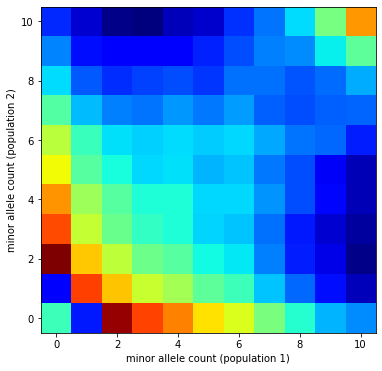

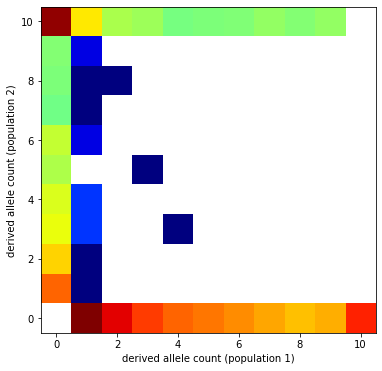

In [40]:
empirical_jsfs = allel.joint_sfs_folded(ac2,ac3)
allel.plot_joint_sfs_folded(empirical_jsfs)
mean_sim_afs = np.mean(sim_afs[1:100], axis=0)
mean_sim_afs.shape
allel.plot_joint_sfs(mean_sim_afs)

Yikes—a huge abundance of private alleles in both populations that do not reflect empirical reality. Let's now try and fit a strict isolation model, as across all optimizations this demographic history had the highest median likelihood, even if no individual optimization could match the likelihood value of the single best parameter optimization for secondary contact.

In [52]:
def wagtail_history_si():

    # maximum likelihood values for population sizes in absolute units...
    n_alba = 10193095
    n_alba_initial = 526278
    n_personata = 9802845
    n_personata_initial = 495549
    
    #...split times in generations / years...
    t_split = 2006422
    
    # growth rates...
    alba_ratio = n_alba/n_alba_initial
    alba_tmp = math.log(alba_ratio)
    alba_rate = alba_tmp/t_split
    personata_ratio = n_personata/n_personata_initial
    personata_tmp = math.log(personata_ratio)
    personata_rate = personata_tmp/t_split
    
    #...and proportional migration rates
    m_alba_personata = 0
    m_personata_alba = 0
    
    # population configurations indices: 0=alba, 1=personata
    population_configurations = [
        msprime.PopulationConfiguration(sample_size=10, 
                                        initial_size=n_alba, 
                                        growth_rate=alba_rate),
        msprime.PopulationConfiguration(sample_size=10, 
                                        initial_size=n_personata,
                                        growth_rate=personata_rate),
    ]
    
    # migration matrix based on those indices
    migration_matrix = [
        [0, 0],
        [0, 0],
    ]
    
    # demographic events: cessation of hybridization + initial divergence
    demographic_events = [
        msprime.PopulationParametersChange(time = t_split, growth_rate = 0, population = 0),
        msprime.PopulationParametersChange(time = t_split, growth_rate = 0, population = 1),
        msprime.MassMigration(time=t_split, source=1, destination=0, proportion=1.0),
    ]
    
    # return matrix objects
    return {
        "population_configurations": population_configurations,
        "migration_matrix": migration_matrix,
        "demographic_events": demographic_events,
    }

In [53]:
dd_si = msprime.DemographyDebugger(**wagtail_history_si())
dd_si.print_history()

Model =  hudson(reference_size=1)
Epoch: 0 -- 2006422.0 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |1.02e+07 5.26e+05       1.48e-06 |     0        0    
1 | 9.8e+06 4.96e+05       1.49e-06 |     0        0    

Events @ generation 2006422.0
   - Population parameter change for 0: growth_rate -> 0 
   - Population parameter change for 1: growth_rate -> 0 
   - Mass migration: Lineages moved with probability 1.0 backwards in time with source 1 & dest 0
                     (equivalent to migration from 0 to 1 forwards in time)
Epoch: 2006422.0 -- inf generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |5.26e+05 5.26e+05              0 |     0        0    
1 |4.96e+05 4.96e+05              0 |     0        0    



In [59]:
sim_si_afs = replicate_simulations(100, wagtail_history_si())

        empirical                          simulated
Pi      0.005314163319711882		0.01230411421052605
Dxy     0.005516508746638577		0.014017585999999627
Fst     0.06371249429456141		0.14813024662544552


<AxesSubplot:xlabel='derived allele count (population 1)', ylabel='derived allele count (population 2)'>

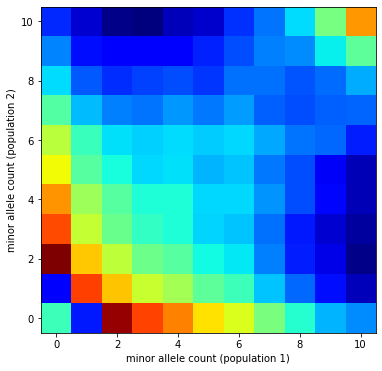

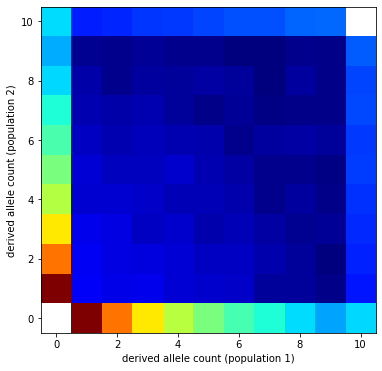

In [62]:
allel.plot_joint_sfs_folded(empirical_jsfs)
mean_sim_si_afs = np.mean(sim_si_afs[1:100], axis=0)
mean_sim_si_afs.shape
allel.plot_joint_sfs(mean_sim_si_afs)

Closer, but still not very good: we're now overestimating $\pi$ and $D_{xy}$ as well as $F_{ST}$. The failure of either of these models to generate similar sequences to our empirical data suggest the low differentiation may be hindering model fit.